<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-Training-Patches" data-toc-modified-id="Create-Training-Patches-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create Training Patches</a></span></li><li><span><a href="#Create-BoVW" data-toc-modified-id="Create-BoVW-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create BoVW</a></span></li><li><span><a href="#Train-an-SVM-Classifier" data-toc-modified-id="Train-an-SVM-Classifier-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train an SVM Classifier</a></span></li><li><span><a href="#Make-Predictions" data-toc-modified-id="Make-Predictions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Make Predictions</a></span></li><li><span><a href="#One-vs-All" data-toc-modified-id="One-vs-All-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>One vs All</a></span></li><li><span><a href="#Optimization" data-toc-modified-id="Optimization-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Optimization</a></span></li><li><span><a href="#Classifier-optimization" data-toc-modified-id="Classifier-optimization-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Classifier optimization</a></span></li><li><span><a href="#MLP-Classifier-Optimization" data-toc-modified-id="MLP-Classifier-Optimization-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>MLP Classifier Optimization</a></span></li><li><span><a href="#SVM-Optimization" data-toc-modified-id="SVM-Optimization-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>SVM Optimization</a></span></li><li><span><a href="#PCA-2D-Prediction-Plot" data-toc-modified-id="PCA-2D-Prediction-Plot-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>PCA 2D Prediction Plot</a></span></li><li><span><a href="#Varying-window-size" data-toc-modified-id="Varying-window-size-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Varying window size</a></span></li><li><span><a href="#Optimizing-best-window-size" data-toc-modified-id="Optimizing-best-window-size-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Optimizing best window size</a></span></li><li><span><a href="#Submission" data-toc-modified-id="Submission-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Submission</a></span></li></ul></div>

In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath('../../'))

In [51]:
import logging
from random import shuffle

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import normalize, scale
from sklearn.svm import SVC
from matplotlib.pyplot import figure
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
import pandas as pd
from tpot import TPOTClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import itertools
import warnings
warnings.filterwarnings('ignore')

from src.misc.data import load_labelled, load_unlabelled
from src.misc.ops import crop_to_square, resize
from src.misc.visualise import *

In [3]:
# Set up logging.
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)

# Load training data.
x, y = load_labelled('../../data/training')
labels = sorted(set(y))

# Load testing data.
# x_test = load_unlabelled('../../data/testing')

INFO: Loading labelled data from C:\Users\hp\Desktop\University of Southampton\MSc AI\Computer Vision\Assignments\3\comp6223-scene-recognition-master\src\misc/../../data/training.
INFO: Class name          Number of samples   
INFO: ----------------------------------------
INFO: bedroom             100                 
INFO: Coast               100                 
INFO: Forest              100                 
INFO: Highway             100                 
INFO: industrial          100                 
INFO: Insidecity          100                 
INFO: kitchen             100                 
INFO: livingroom          100                 
INFO: Mountain            100                 
INFO: Office              100                 
INFO: OpenCountry         100                 
INFO: store               100                 
INFO: Street              100                 
INFO: Suburb              100                 
INFO: TallBuilding        100                 
INFO: Loaded 15 class

In [4]:
# x_cropped = [crop_to_square(image) for image in x]
# x_resized = [resize(image, 64, cv.INTER_AREA) for image in x_cropped]
x_np = np.array(x)
y_np = np.array(y)

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=2019)
for train_index, test_index in sss.split(x_np, y_np):
    x_train, x_test = x_np[train_index], x_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]

In [6]:
def get_patches(img, window=8, step=4):
    """
    Code taken from https://answers.opencv.org/question/55638/what-is-the-fastest-way-to-do-patch-based-image-analysis/
    :param img:
    :param window:
    :param step:
    :return:
    """
    overlap = window - step
    h, w = img.shape

    gridx = range(0, w - window, window - overlap)
    gridx = np.hstack((gridx, w - window))

    gridy = range(0, h - window, window - overlap)
    gridy = np.hstack((gridy, h - window))

    patches = np.array([[img[yy: yy + window, xx: xx + window] for xx in gridx] for yy in gridy])
    # NOTE: If you need the patches to be 2D, uncomment the line below.
    # return patches.reshape(patches.shape[0] * patches.shape[1], window , window)
    return patches.reshape(patches.shape[0] * patches.shape[1], window * window)

In [7]:
flatten = lambda l: (item for sublist in l for item in sublist)
patchgen = lambda x: (get_patches(img) for img in x)
zero_mean = lambda x: (scale(patches) for patches in x)
unit_len = lambda x: (normalize(patches) for patches in x)
histgen = lambda x, quantizer: (np.histogram(
    quantizer.predict(patches),
    bins=quantizer.cluster_centers_.shape[0],
#     bins=500,
    density=False)[0]/quantizer.cluster_centers_.shape[0] for patches in x)

## Create Training Patches

In [8]:
patches_train = list(unit_len(zero_mean(patchgen(x_train))))
patches_test = list(unit_len(zero_mean(patchgen(x_test))))
bovw_train = list(flatten(patches_train))

## Create BoVW

In [9]:
kmeans = MiniBatchKMeans(n_clusters=50, random_state=2019, batch_size=50000)

In [10]:
kmeans.fit(bovw_train)

MiniBatchKMeans(batch_size=50000, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=50, n_init=3, random_state=2019,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [11]:
# Save the quantizer if necessary
# dump(kmeans, 'mbkmeans_nocrop_unit_0mean_50clusters.joblib')

## Train an SVM Classifier

In [12]:
# Load a quantizer if needed
# kmeans = load('last_use_me.joblib')

In [13]:
# Make the train and test histograms
svm_train = list(histgen(patches_train, kmeans))
svm_test = list(histgen(patches_test, kmeans))

In [14]:
svm = SVC(kernel='linear', C=4.0)

In [15]:
svm.fit(svm_train, y_train)

SVC(C=4.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [16]:
# Save the classifier if neccessary
# dump(svm, 'svm.joblib')

In [17]:
y_pred = svm.predict(svm_train)

In [18]:
accuracy = accuracy_score(y_train, y_pred)
accuracy

0.8776119402985074

## Make Predictions

In [19]:
y_pred = svm.predict(svm_test)

In [20]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.5131313131313131

## One vs All

In [21]:
clf = OneVsRestClassifier(SVC(kernel='linear', C=4.0)).fit(svm_train, y_train)
y_pred = svm.predict(svm_train)
accuracy_score(y_train, y_pred)

0.8776119402985074

In [22]:
y_pred = clf.predict(svm_test)
accuracy_score(y_test, y_pred)

0.4626262626262626

## Optimization

In [23]:
n_cls = []
acc = []
for size in range(50, 800, 100):
    kmeans = MiniBatchKMeans(n_clusters= size, random_state=2019, batch_size=50000)
    kmeans.fit(bovw_train)
    svm_train = list(histgen(patches_train, kmeans))
    svm_test = list(histgen(patches_test, kmeans))
    clf = OneVsRestClassifier(SVC(kernel='linear', C=4.0)).fit(svm_train, y_train)
    y_pred = clf.predict(svm_test)
    res = accuracy_score(y_test, y_pred)
    print("Number of clusters: " + str(size) + ", Accuracy: " + str(res))
    acc.append(res)
    n_cls.append(size)

Number of clusters: 50, Accuracy: 0.4626262626262626
Number of clusters: 150, Accuracy: 0.5070707070707071
Number of clusters: 250, Accuracy: 0.5373737373737374
Number of clusters: 350, Accuracy: 0.5131313131313131
Number of clusters: 450, Accuracy: 0.4707070707070707
Number of clusters: 550, Accuracy: 0.48282828282828283
Number of clusters: 650, Accuracy: 0.5292929292929293
Number of clusters: 750, Accuracy: 0.48282828282828283


Text(0.5, 1.0, 'Number of Clusters Optimization')

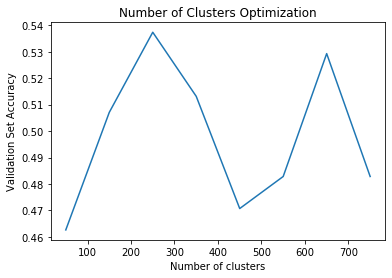

In [24]:
plt.plot(n_cls, acc)
plt.xlabel('Number of clusters')
plt.ylabel('Validation Set Accuracy')
plt.title('Number of Clusters Optimization')
plt.ylim([0, 1])

## Classifier optimization

In [26]:
kmeans = MiniBatchKMeans(n_clusters= 250, random_state=2019, batch_size=50000)
kmeans.fit(bovw_train)
svm_train = list(histgen(patches_train, kmeans))
svm_test = list(histgen(patches_test, kmeans))

In [38]:
clf = OneVsRestClassifier(SVC(kernel='linear', C=4.0)).fit(svm_train, y_train)
y_pred = clf.predict(svm_test)
accuracy_score(y_test, y_pred)

0.5373737373737374

In [39]:
models = [('Support Vector Machine', SVC()), 
          ('Naive Bayes', GaussianNB()), 
          ('MLPClassifier',  MLPClassifier()), 
          ('Random Forest', RandomForestClassifier()), 
          ('AdaBoostClassifier', AdaBoostClassifier()),
          ('GaussianProcess', GaussianProcessClassifier()),
          ('DecisionTree', DecisionTreeClassifier()),
          ('KNearest',  KNeighborsClassifier())]
results = []
names = []
for name, model in models:
    clf = OneVsRestClassifier(model).fit(svm_train, y_train)
    y_pred = clf.predict(svm_test)
    res = accuracy_score(y_test, y_pred)
    results.append(res)
    names.append(name)
    print(str(name) + ' accuracy: ' + str(res))

Support Vector Machine accuracy: 0.46060606060606063
Naive Bayes accuracy: 0.296969696969697
MLPClassifier accuracy: 0.5616161616161616
Random Forest accuracy: 0.43232323232323233
AdaBoostClassifier accuracy: 0.47474747474747475
GaussianProcess accuracy: 0.3333333333333333
DecisionTree accuracy: 0.2080808080808081
KNearest accuracy: 0.26666666666666666


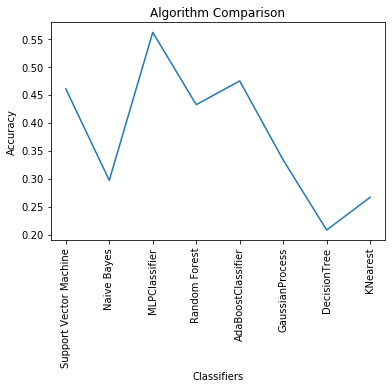

In [56]:
plt.title('Algorithm Comparison')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Classifiers')
plt.plot(names, results)
plt.ylim([0, 1])
plt.show()

## MLP Classifier Optimization

Using genetic algorithms by creating a population of different models with different parameters to determine which combination of hyperparameters can lead to the best classification results. 

In [69]:
le = preprocessing.LabelEncoder()
train = le.fit_transform(y_train)
enc = le.fit_transform(y_test)

In [70]:
parameters = {'solver': ['lbfgs', 'sgd', 'adam'],
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'hidden_layer_sizes' : [(100,), (50, 50), (20, 70), (70, 20)],
              'alpha': list(np.linspace(0.00001, 0.01, 10, dtype = float))}
               
tpot_classifier = TPOTClassifier(generations= 5, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 12,
                                 config_dict= {'sklearn.neural_network.MLPClassifier': parameters}, 
                                 cv = 4, scoring = 'accuracy')
tpot_classifier.fit(np.array(svm_train), train)

Generation 1 - Current best internal CV score: 0.5876225490196079
Generation 2 - Current best internal CV score: 0.5876225490196079
Generation 3 - Current best internal CV score: 0.5876225490196079
Generation 4 - Current best internal CV score: 0.5876225490196079
Generation 5 - Current best internal CV score: 0.5876225490196079

Best pipeline: MLPClassifier(CombineDFs(input_matrix, input_matrix), activation=relu, alpha=0.0077800000000000005, hidden_layer_sizes=(100,), solver=adam)


TPOTClassifier(config_dict={'sklearn.neural_network.MLPClassifier': {'activation': ['identity',
                                                                                    'logistic',
                                                                                    'tanh',
                                                                                    'relu'],
                                                                     'alpha': [1e-05,
                                                                               0.0011200000000000001,
                                                                               0.00223,
                                                                               0.0033400000000000005,
                                                                               0.00445,
                                                                               0.00556,
                                                                     

In [71]:
acc6 = tpot_classifier.score(np.array(svm_test), enc)
print(acc6)

0.5757575757575758


In [92]:
tpot_classifier.export('tpot_pipeline.py')

In [93]:
tpot_classifier.fitted_pipeline_

Pipeline(memory=None,
         steps=[('featureunion',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('functiontransformer-1',
                                                 FunctionTransformer(accept_sparse=False,
                                                                     check_inverse=True,
                                                                     func=<function copy at 0x000001ED9C91BE18>,
                                                                     inv_kw_args=None,
                                                                     inverse_func=None,
                                                                     kw_args=None,
                                                                     pass_y='deprecated',
                                                                     validate=None)),
                                                ('functiontransformer-2',
                            

In [94]:
clf = OneVsRestClassifier(MLPClassifier(batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(100,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_iter=200,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False)).fit(svm_train, y_train)
y_pred = clf.predict(svm_test)
accuracy_score(y_test, y_pred)

0.597979797979798

## SVM Optimization

In [96]:
parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
              'C': list(np.linspace(0.01, 2, 10, dtype = float))}
               
tpot_classifier = TPOTClassifier(generations= 5, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 12,
                                 config_dict= {'sklearn.svm.SVC': parameters}, 
                                 cv = 4, scoring = 'accuracy')
tpot_classifier.fit(np.array(svm_train), train)

Generation 1 - Current best internal CV score: 0.5306985294117648
Generation 2 - Current best internal CV score: 0.5449754901960784
Generation 3 - Current best internal CV score: 0.5487745098039216
Generation 4 - Current best internal CV score: 0.5487745098039216
Generation 5 - Current best internal CV score: 0.5487745098039216

Best pipeline: SVC(CombineDFs(CombineDFs(input_matrix, CombineDFs(input_matrix, input_matrix)), input_matrix), C=1.3366666666666667, kernel=linear)


TPOTClassifier(config_dict={'sklearn.svm.SVC': {'C': [0.01, 0.23111111111111113,
                                                      0.45222222222222225,
                                                      0.6733333333333333,
                                                      0.8944444444444445,
                                                      1.1155555555555556,
                                                      1.3366666666666667,
                                                      1.557777777777778,
                                                      1.778888888888889, 2.0],
                                                'kernel': ['linear', 'poly',
                                                           'rbf', 'sigmoid',
                                                           'precomputed']}},
               crossover_rate=0.1, cv=4, disable_update_check=False,
               early_stop=12, generations=5, max_eval_time_mins=5,
               max_time_mins=

In [97]:
acc6 = tpot_classifier.score(np.array(svm_test), enc)
print(acc6)

0.5434343434343434


In [98]:
tpot_classifier.fitted_pipeline_

Pipeline(memory=None,
         steps=[('featureunion',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('featureunion',
                                                 FeatureUnion(n_jobs=None,
                                                              transformer_list=[('functiontransformer',
                                                                                 FunctionTransformer(accept_sparse=False,
                                                                                                     check_inverse=True,
                                                                                                     func=<function copy at 0x000001ED9C91BE18>,
                                                                                                     inv_kw_args=None,
                                                                                                     inverse_func=None,
                               

In [99]:
clf = OneVsRestClassifier(SVC(C=1.3366666666666667, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False)).fit(svm_train, y_train)
y_pred = clf.predict(svm_test)
accuracy_score(y_test, y_pred)

0.5151515151515151

## PCA 2D Prediction Plot

In [76]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(svm_train)
PCA_df = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2'])
y_pca = pd.DataFrame(data = train, columns = ['class'])
PCA_df = pd.concat([PCA_df, y_pca], axis = 1)
PCA_df['class'] = preprocessing.LabelEncoder().fit_transform(PCA_df['class'])
PCA_df.head()

,PC1,PC2,class
0,-1.121641,0.054272,12
1,1.888561,-1.109143,13
2,0.235155,-2.236988,13
3,-1.280683,-0.981403,3
4,-1.486369,-1.785408,11


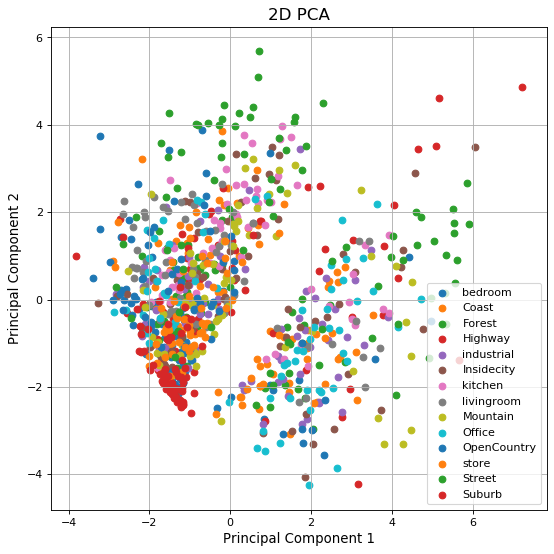

In [90]:
figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

classes = [i for i in range(14, 0, -1)]
for clas in classes:
    plt.scatter(PCA_df.loc[PCA_df['class'] == clas, 'PC1'], 
                PCA_df.loc[PCA_df['class'] == clas, 'PC2'])
    
plt.xlabel('Principal Component 1', fontsize = 12)
plt.ylabel('Principal Component 2', fontsize = 12)
plt.title('2D PCA', fontsize = 15)
plt.legend(sorted(set(y), key=str.casefold))
plt.grid()

## Varying window size

In [17]:
wind = []
acc = []
for size in range(8, 33, 8):
    patches_train = list(unit_len(zero_mean([get_patches(img, window=size, step=int(size/2)) for img in x_train])))
    patches_test = list(unit_len(zero_mean([get_patches(img, window=size, step=int(size/2)) for img in x_test])))
    bovw_train = list(flatten(patches_train))
    kmeans = MiniBatchKMeans(n_clusters= 250, random_state=2019, batch_size=50000)
    kmeans.fit(bovw_train)
    svm_train = list(histgen(patches_train, kmeans))
    svm_test = list(histgen(patches_test, kmeans))
    clf = OneVsRestClassifier(MLPClassifier(batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(100,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_iter=200,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False)).fit(svm_train, y_train)
    y_pred = clf.predict(svm_test)
    res = accuracy_score(y_test, y_pred)
    print("Window Size: " + str(size) + ', Step Size: ' + str(int(size/2)) + ", Accuracy: " + str(res))
    acc.append(res)
    wind.append(size)

Window Size: 8, Step Size: 4, Accuracy: 0.593939393939394
Window Size: 16, Step Size: 8, Accuracy: 0.46060606060606063
Window Size: 24, Step Size: 12, Accuracy: 0.4101010101010101
Window Size: 32, Step Size: 16, Accuracy: 0.27070707070707073


In [21]:
wind2 = []
acc2 = []
for size in range(2, 5, 2):
    patches_train = list(unit_len(zero_mean([get_patches(img, window=size, step=int(size/2)) for img in x_train])))
    patches_test = list(unit_len(zero_mean([get_patches(img, window=size, step=int(size/2)) for img in x_test])))
    bovw_train = list(flatten(patches_train))
    kmeans = MiniBatchKMeans(n_clusters= 250, random_state=2019, batch_size=50000)
    kmeans.fit(bovw_train)
    svm_train = list(histgen(patches_train, kmeans))
    svm_test = list(histgen(patches_test, kmeans))
    clf = OneVsRestClassifier(MLPClassifier(batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(100,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_iter=200,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False)).fit(svm_train, y_train)
    y_pred = clf.predict(svm_test)
    res = accuracy_score(y_test, y_pred)
    print("Window Size: " + str(size) + ', Step Size: ' + str(int(size/2)) + ", Accuracy: " + str(res))
    acc2.append(res)
    wind2.append(size)

Window Size: 2, Step Size: 1, Accuracy: 0.5434343434343434
Window Size: 4, Step Size: 2, Accuracy: 0.6121212121212121


In [22]:
acc_res = acc2.extend(acc)
wind_res = wind2.extend(wind)

(0, 1)

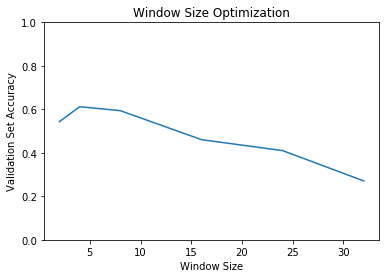

In [27]:
plt.plot(wind2, acc2)
plt.xlabel('Window Size')
plt.ylabel('Validation Set Accuracy')
plt.title('Window Size Optimization')
plt.ylim([0, 1])

## Optimizing best window size

In [34]:
patches_train = list(unit_len(zero_mean([get_patches(img, window=4, step=2) for img in x_train])))
patches_test = list(unit_len(zero_mean([get_patches(img, window=4, step=2) for img in x_test])))
bovw_train = list(flatten(patches_train))
kmeans = MiniBatchKMeans(n_clusters= 250, random_state=2019, batch_size=50000)
kmeans.fit(bovw_train)
svm_train = list(histgen(patches_train, kmeans))
svm_test = list(histgen(patches_test, kmeans))

In [44]:
clf = OneVsRestClassifier(MLPClassifier(batch_size='auto', beta_1=0.9, beta_2=0.999,
                           early_stopping=False, epsilon=1e-08,
                           hidden_layer_sizes=(100,),
                           learning_rate='constant',
                           learning_rate_init=0.001, max_iter=200,
                           momentum=0.9, n_iter_no_change=10,
                           nesterovs_momentum=True, power_t=0.5,
                           random_state=None, shuffle=True, solver='adam',
                           tol=0.0001, validation_fraction=0.1,
                           verbose=False, warm_start=False)).fit(svm_train, y_train)
y_pred = clf.predict(svm_test)
res = accuracy_score(y_test, y_pred)
res

0.6101010101010101

In [45]:
dump(clf, 'run2_mlp.joblib')

['run2_mlp.joblib']

In [58]:
clf = load('run2_mlp.joblib') 
y_pred = clf.predict(svm_test)
accuracy_score(y_test, y_pred)

0.6101010101010101

<Figure size 432x288 with 0 Axes>

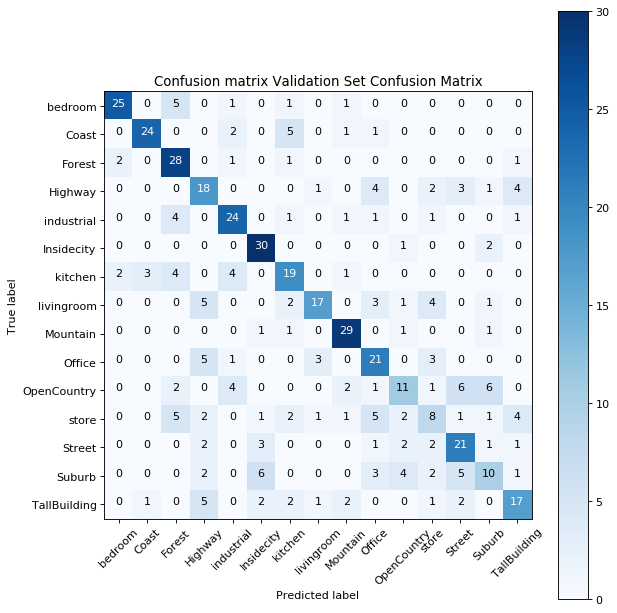

In [56]:
# Thanks to: https://www.kaggle.com/tejainece/data-visualization-and-machine-learning-algorithms
def plot_confusion_matrix(cm, classes, title="",
                          cmap=plt.cm.Blues):
    figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix ' + title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot = confusion_matrix(y_test, y_pred)

plt.figure()
plot_confusion_matrix(cm_plot, sorted(set(y), key=str.casefold),  title = 'Validation Set Confusion Matrix')

## Submission

In [60]:
# Creating submission file
# When using load_unlabelled in what order are the images loaded? Using this method is assumed the
# order is 0.jpg, 1.jpg, 2.jpg, 3.jpg, etc.. (for example, when using glob the images gets loaded by
# default in a binary like order 0.jpg, 1.jpg, 10.jpg, 11.jpg, etc...)

import glob

filenames = glob.glob('../../data/testing/*.jpg')
x_test2 = load_unlabelled('../../data/testing')
x_test2 = np.array(x_test2)

INFO: Loading unlabelled data from C:\Users\hp\Desktop\University of Southampton\MSc AI\Computer Vision\Assignments\3\comp6223-scene-recognition-master\src\misc/../../data/testing.
INFO: Total number of samples is 2985.


In [61]:
patches_test2 = list(unit_len(zero_mean([get_patches(img, window=4, step=2) for img in x_test2])))
svm_test2 = list(histgen(patches_test2, kmeans))

file = open("run2.txt","w") 
res = [i.split('\\')[1] for i in filenames]
res2 = [int(i.split('.')[0]) for i in res]
res2.sort()

preds = clf.predict(svm_test2)
 
for name, pred in zip([str(i) + '.jpg' for i in res2], preds):
    file.write(name + ' ' + pred + '\n') 

file.close() 